In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import mikkel_tools.GMT_tools as gt

# ChaosMagPy modules
from chaosmagpy import load_CHAOS_matfile
from chaosmagpy.model_utils import synth_values
from chaosmagpy.data_utils import mjd2000

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Swarm observations with tapered ensemble as prior"
nb_name = "nb_case_core_vires_swarm_obs"

# 1 year, 6nT C_e, SV removed

In [2]:
shc_g = 30
shc_grid = 30

str_load = "Ce6_PT5M_Sy2018m11d1_Ey2019m11d1_Np500"
C_e_const = 6
samp = "PT5M"
date_start = [2018,11,1]
date_end = [2019,11,1]

file_pickle = open("{}_{}.obj".format(nb_name,str_load), 'rb')
core = pickle.load(file_pickle)
file_pickle.close()
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = False)
core.generate_map()

# Swarm obs
import datetime as dt
from viresclient import SwarmRequest
request = SwarmRequest()
collect = "SW_OPER_MAGA_LR_1B"
use_meas = ["B_NEC"]
use_aux = ["SunZenithAngle", "Kp", "QDLat", "Dst", "IMF_BZ_GSM"]
use_models = ["LCS1='LCS-1'(min_degree=1, max_degree=185)", "CHAOS-MMA", "MIO_SHA_2C"] # "CHAOS='CHAOS-Core'(min_degree=15, max_degree=20)"
request.set_collection(collect)
request.set_products(measurements=use_meas,
                     models = use_models,
                     auxiliaries=use_aux,
                     residuals=False,
                     sampling_step=samp)

data = request.get_between(start_time=dt.datetime(date_start[0],date_start[1],date_start[2]),
                           end_time=dt.datetime(date_end[0],date_end[1],date_end[2]))
ds = data.as_xarray()
SZA_angle = 120
Kp_max = 2
dDst_dt_max = 2
Dst_abs_max = 30
QDlat_max = 90
IMF_BZ_min = 0.0
dDst_dt = (abs(np.diff(ds.Dst.values,prepend=0))/5)*60 #(nT/5min)/5 * 60min/hr -> nT/hr
Dst_abs = abs(ds.Dst.values)
idx_sort = np.logical_and.reduce((np.abs(ds.SunZenithAngle.values)>SZA_angle, 
                                  ds.Kp.values<=Kp_max, abs(ds.QDLat.values)<QDlat_max, 
                                  dDst_dt<=dDst_dt_max, Dst_abs < Dst_abs_max,
                                  ds.IMF_BZ_GSM>IMF_BZ_min))

obs_sat = SDSS(comment, N_SH = shc_g)
obs_sat.r_grid = ds.Radius[idx_sort].values/10**3
obs_sat.lon = ds.Longitude[idx_sort].values
obs_sat.lat = ds.Latitude[idx_sort].values
obs_sat.grid_N = len(obs_sat.lat)
print(obs_sat.grid_N)

# chaosmagpy
N_chaos = 20
CHAOS7 = load_CHAOS_matfile('mikkel_tools/models_shc/CHAOS-7.mat')
# Start
chaos_time = mjd2000(date_start[0],date_start[1],date_start[2])
g_CHAOS7 = CHAOS7.synth_coeffs_tdep(chaos_time, nmax=20, deriv=0)
A_r, A_theta, A_phi = gt.design_SHA(obs_sat.r_grid/core.a, (90-obs_sat.lat)*core.rad, obs_sat.lon*core.rad, N_chaos)
B_CHAOS7_start = np.matmul(A_r,g_CHAOS7)

M_use = ds["B_NEC_LCS1"].values[:,2][idx_sort] + ds["B_NEC_CHAOS-MMA"].values[:,2][idx_sort] #+ ds["B_NEC_MIO_SHA_2C"].values[:,2][idx_sort]  

B_delta_SV =-ds["B_NEC"].values[:,2][idx_sort] + M_use - B_CHAOS7_start

obs_sat.data = -ds["B_NEC"].values[:,2][idx_sort] + M_use - B_delta_SV


[1/1] Processing:  100%|██████████|  [ Elapsed: 03:37, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (17.92MB)


4884


<IPython.core.display.Javascript object>


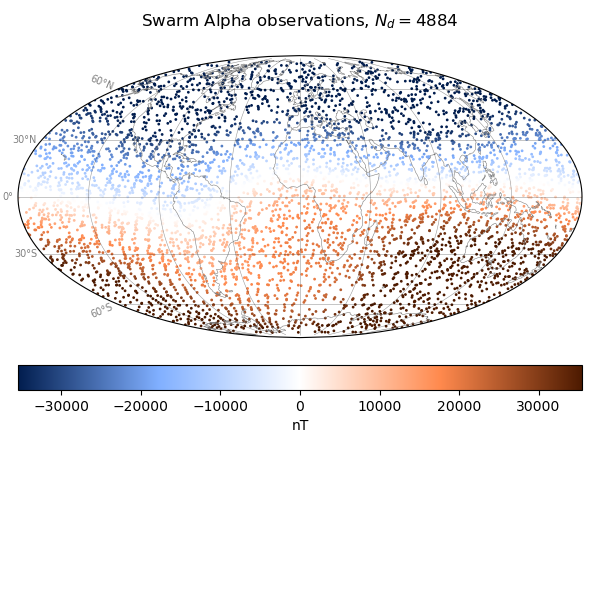

<IPython.core.display.Javascript object>


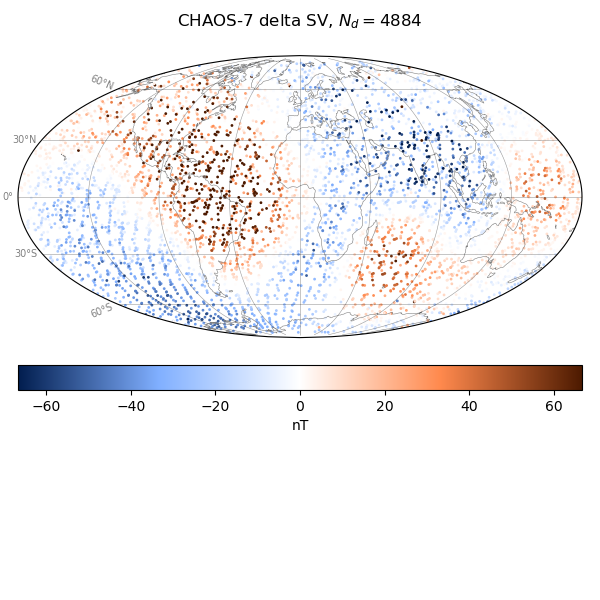

<IPython.core.display.Javascript object>


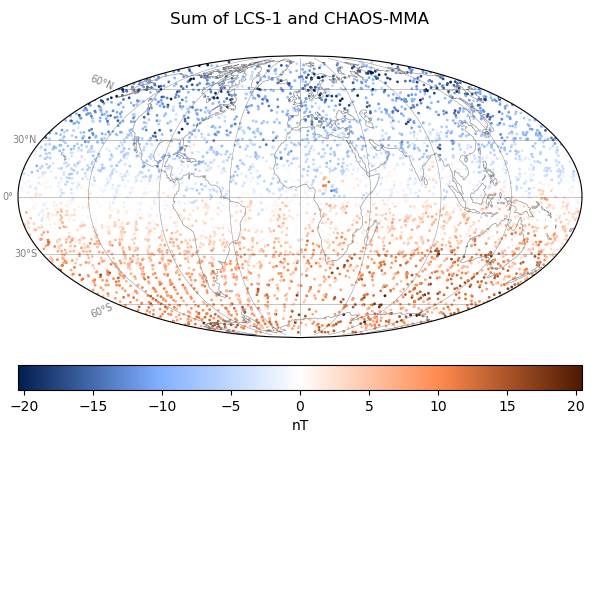

In [3]:
mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=obs_sat.data, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Swarm Alpha observations, $N_d={}$'.format(obs_sat.grid_N), point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_core_vires_swarm_obs", save_path = "images/",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=B_delta_SV, limits_data = [-100,100],
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='CHAOS-7 delta SV, $N_d={}$'.format(obs_sat.grid_N), point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_core_vires_swarm_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = obs_sat.lat, lon = obs_sat.lon, data=-M_use, 
                cbar_h = 0.075, cbar_mm_factor = 2/3, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Sum of LCS-1 and CHAOS-MMA', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

All eigenvalues > 0: True
Cov model is pos def: True


<IPython.core.display.Javascript object>


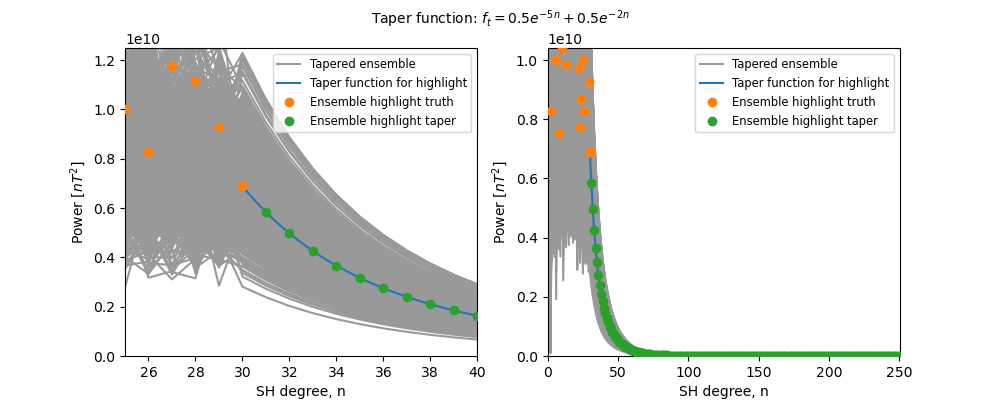

In [4]:
core.cov_model_taper(r_at = core.r_cmb, tap_to = 500, tap_exp_p1 = 5, tap_exp_p2 = 2,
                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True)

In [5]:
core.integrating_kernel(obs_sat, C_e_const = C_e_const, C_mm_supply = core.C_ens_tap)

In [6]:
core.covmod_lsq_equiv(obs_sat.data, core.C_ens_tap, core.G, core.r_cmb)

In [7]:
print(core)


______current attributes______

a:                  6371.2
r_sat:              6721.2
r_cmb:              3480.0
rad:                0.017453292519943295
mu0:                1.2566370614359173e-06
comment:            Swarm observations with tapered ensemble as prior
class_abs_path:     /home/mikotz/spherical_direct_sequential_simulation
N_SH:               30
N_SH_secondary:     None
sim_type:           core_ens
grid_zero:          (31,), Max/Min: 1.00 / -1.00
grid_w_shtools:     (31,), Max/Min: 0.10 / 0.01
grid_shape:         (2,), Max/Min: 61.00 / 31.00
grid_w:             (1891,), Max/Min: 0.10 / 0.01
grid_radial:        (1891,), Max/Min: 3480.00 / 3480.00
grid_theta:         (1891,), Max/Min: 175.63 / 4.37
grid_phi:           (1891,), Max/Min: 354.10 / 0.00
grid_N:             1891
grid_nmax:          30
r_grid:             3480.0
grid:               (1891, 2)
sph_d:              None
lon:                (1891,), Max/Min: 354.10 / 0.00
lat:                (1891,), Max/Min: 85.63 /

# My own SH transform

In [344]:
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_radial = core.grid_radial
grid_theta = core.grid_theta
grid_phi = core.grid_phi

r_at = core.r_cmb

# Generate design matrix for grid
A_r, _, _ = gt.design_SHA(r_at/core.a, grid_theta*core.rad, grid_phi*core.rad, 30)

B_r_spec = A_r@core.g_spec[:,0].reshape(-1,1)

n_G = 42

#g_use = g_use[:mt_util.shc_vec_len(nmax)]

grid_radial = core.grid_radial
grid_theta = core.grid_theta
grid_phi = core.grid_phi

# Generate design matrix for grid
A_r_lsq, _, _ = gt.design_SHA(r_at/core.r_cmb, grid_theta*core.rad, grid_phi*core.rad, n_G)


#B_r A_r@g

#B_r = np.mean(core.m_DSS,axis=1).reshape(-1,1)
B_r = core.m_DSS[:,[0]]

#g_Br_lsq, res, rank, v_singular = np.linalg.lstsq(A_r_lsq,B_r,rcond=None)

IdentitySize = A_r_lsq.shape[1]
IdentityMatrix= np.zeros((IdentitySize, IdentitySize))
np.fill_diagonal(IdentityMatrix, 1)

g_Br_lsq, res, rank, v_singular = np.linalg.lstsq(A_r_lsq.T.dot(A_r_lsq) + 2 * IdentityMatrix, A_r_lsq.T.dot(B_r),rcond=-1)

In [345]:
A_r, _, _ = gt.design_SHA(r_at/core.a, grid_theta*core.rad, grid_phi*core.rad, n_G)
import scipy.sparse.linalg as spsl
tol = 1e-14
#x0 = np.concatenate((np.mean(core.g_spec,axis=1),np.zeros((mt_util.shc_vec_len(n_G)-mt_util.shc_vec_len(30),))))
x0 = np.concatenate((core.g_spec[:,0],core.g_spec[-1,0]*np.ones((mt_util.shc_vec_len(n_G)-mt_util.shc_vec_len(30),))))

g_Br, istop, itn, normr, _, _, _, _ = spsl.lsmr(A_r,B_r, damp=0, atol=tol, btol=tol, conlim=100000000.0, maxiter=2*10**5, show=False, x0=x0)

In [346]:
g_Br.shape

(1848,)

In [347]:
A_r.shape

(1891, 1848)

In [348]:
istop

1

In [349]:
itn

4216

In [350]:
R_Br = mt_util.lowe_shspec(n_G,core.r_cmb,core.a,g_Br.reshape(-1,1))

R_Br_lsq = mt_util.lowe_shspec(n_G,core.r_cmb,core.r_cmb,g_Br_lsq.reshape(-1,1))

#R_g_spec = mt_util.lowe_shspec(30,core.r_cmb,core.a,np.mean(core.g_spec,axis=1).reshape(-1,1))
R_g_spec = mt_util.lowe_shspec(30,core.r_cmb,core.a,core.g_spec[:,0].reshape(-1,1))


B_r_lsq = A_r@g_Br.reshape(-1,1)
B_r_slsq = A_r_lsq@g_Br_lsq.reshape(-1,1)

res_m = B_r*10**(-6) - B_r_lsq*10**(-6)
res_m_lsq = B_r*10**(-6) - B_r_slsq*10**(-6)
res_m_spec = B_r*10**(-6) - B_r_spec*10**(-6)

<IPython.core.display.Javascript object>


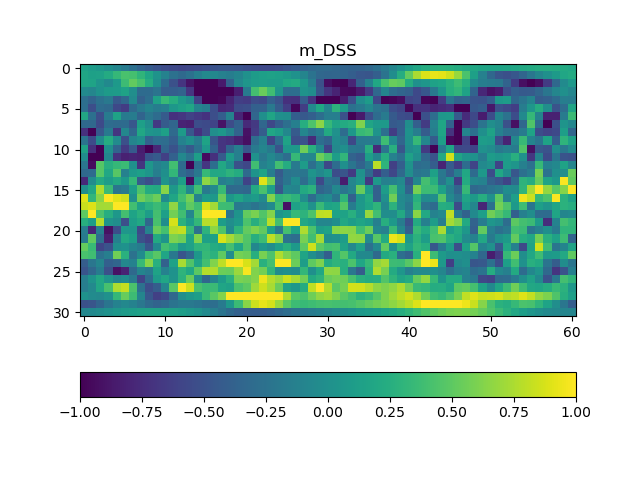

<IPython.core.display.Javascript object>


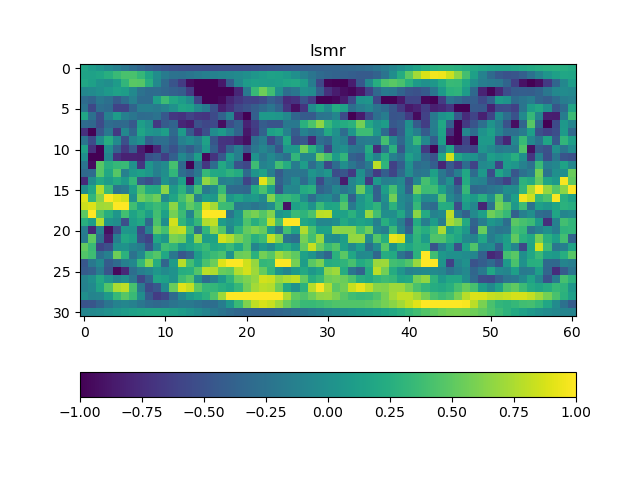

<IPython.core.display.Javascript object>


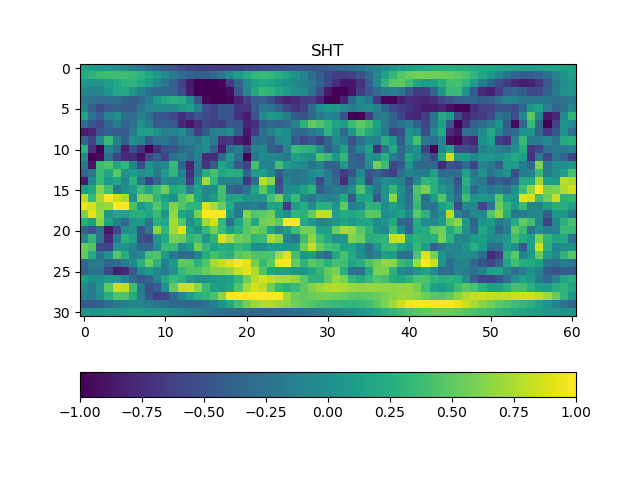

<IPython.core.display.Javascript object>


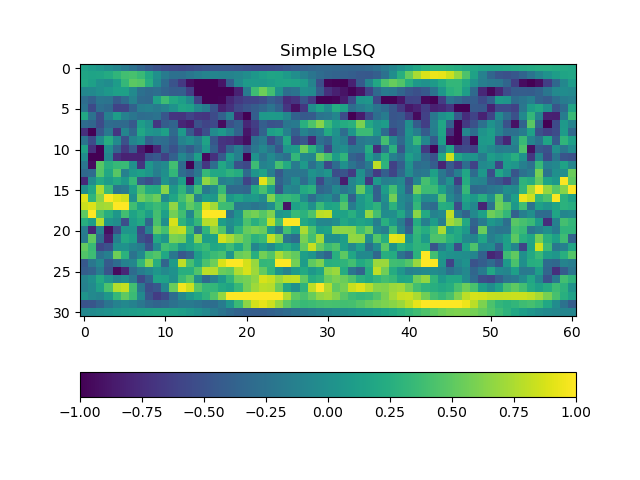

<IPython.core.display.Javascript object>


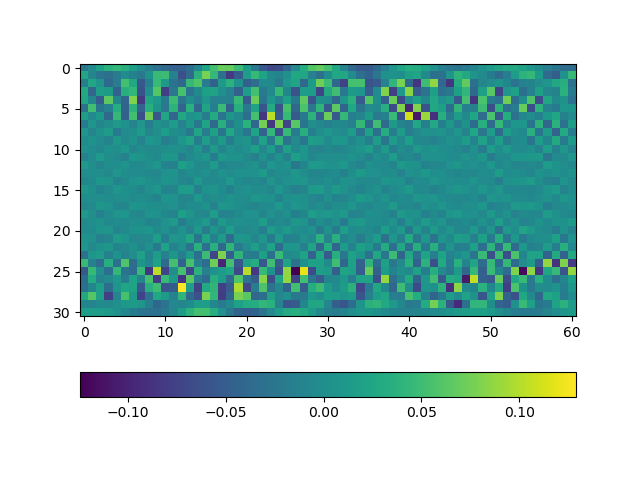

<IPython.core.display.Javascript object>


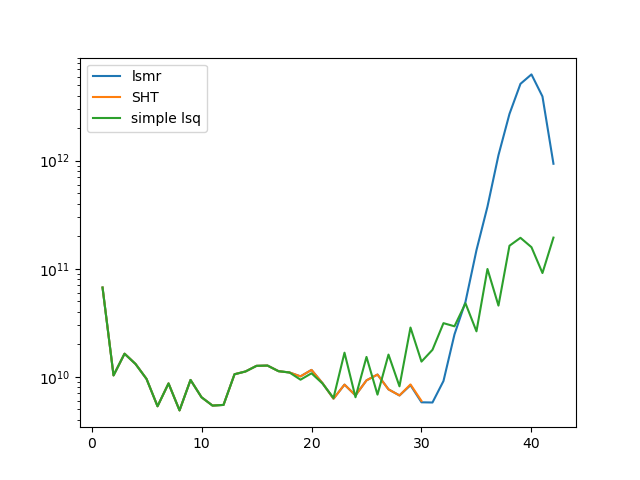

<IPython.core.display.Javascript object>


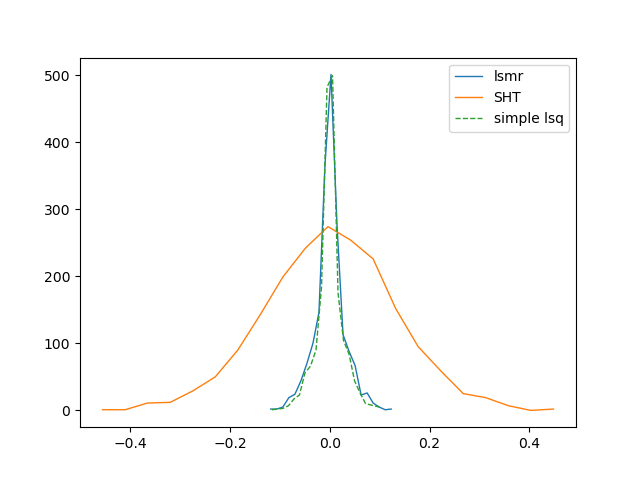

In [351]:
plt.figure()
plt.imshow(B_r.reshape(31,61)*10**(-6), vmin = -1, vmax = 1)
plt.colorbar(orientation='horizontal')
plt.title("m_DSS")
plt.show()

plt.figure()
plt.imshow(B_r_lsq.reshape(31,61)*10**(-6), vmin = -1, vmax = 1)
plt.colorbar(orientation='horizontal')
plt.title("lsmr")
plt.show()

plt.figure()
plt.imshow(B_r_spec.reshape(31,61)*10**(-6), vmin = -1, vmax = 1)
plt.colorbar(orientation='horizontal')
plt.title("SHT")
plt.show()

plt.figure()
plt.imshow(B_r_slsq.reshape(31,61)*10**(-6), vmin = -1, vmax = 1)
plt.colorbar(orientation='horizontal')
plt.title("Simple LSQ")
plt.show()

plt.figure()
plt.imshow(B_r.reshape(31,61)*10**(-6)-B_r_lsq.reshape(31,61)*10**(-6))
plt.colorbar(orientation='horizontal')
plt.show()

plt.figure()
plt.semilogy(np.arange(1,n_G+1),R_Br, label="lsmr")
plt.semilogy(np.arange(1,30+1),R_g_spec, label="SHT")
plt.semilogy(np.arange(1,n_G+1),R_Br_lsq, label="simple lsq")
plt.legend()
plt.show()



plt.figure()
y,binEdges=np.histogram(res_m,bins=21)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters, y, '-', label='lsmr', linewidth = 1,zorder=1)
y,binEdges=np.histogram(res_m_spec,bins=21)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters, y, '-', label='SHT', linewidth = 1,zorder=1)
y,binEdges=np.histogram(res_m_lsq,bins=21)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(bincenters, y, '--', label='simple lsq', linewidth = 1,zorder=1)
plt.legend()
plt.show()

In [308]:
tol = 1e-14
g_lsmr = []
for i in np.arange(0,core.g_spec.shape[1]):
    x0 = np.concatenate((core.g_spec[:,i],core.g_spec[-1,0]*np.ones((mt_util.shc_vec_len(n_G)-mt_util.shc_vec_len(30),))))
    g_Br, istop, itn, normr, _, _, _, _ = spsl.lsmr(A_r,core.m_DSS[:,[i]], damp=0, atol=tol, btol=tol, conlim=100000000.0, maxiter=2*10**5, show=False, x0=x0)
    g_lsmr.append(g_Br)
    
    mt_util.printProgressBar(i,core.g_spec.shape[1]-1)

 |----------| 0.0%  . Counter: 0/499

KeyboardInterrupt: 

In [206]:
g_test = np.array(g_lsmr).T

In [207]:
g_test.shape

(1848, 500)

<IPython.core.display.Javascript object>


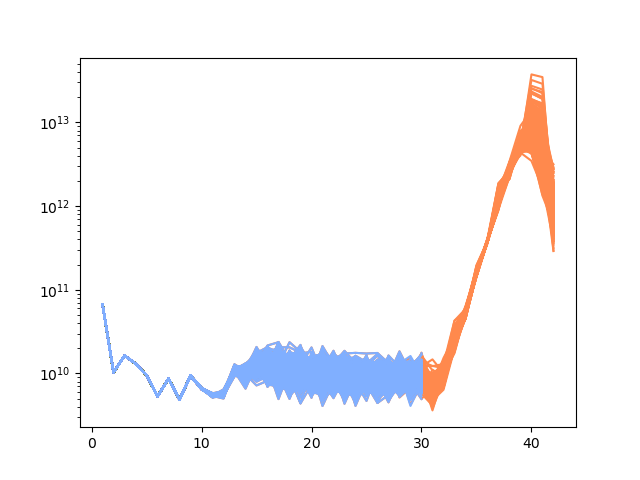

In [209]:
color_rgb_zesty_pos = (1.0,  0.5372549019607843,  0.30196078431372547)
color_rgb_zesty_neg = (0.5019607843137255,  0.6862745098039216,  1.0)

R_lsmr = mt_util.lowe_shspec(n_G,core.r_cmb,core.a,g_test)
R_spec = mt_util.lowe_shspec(30,core.r_cmb,core.a,core.g_spec)

plt.figure()
plt.semilogy(np.arange(1,n_G+1),R_lsmr, label="lsmr",color=color_rgb_zesty_pos)
plt.semilogy(np.arange(1,30+1),R_spec, label="SHT",color=color_rgb_zesty_neg)
#plt.legend()
plt.show()

# Mode

In [8]:
# MODE FROM M
core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
m_DSS_hist = []
m_DSS_hist_y = []
for i in np.arange(0,core.m_DSS.shape[0]):
    y,binEdges=np.histogram(core.m_DSS[i,:],bins=15)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    m_DSS_hist.append(bincenters)
    m_DSS_hist_y.append(y)
    
m_DSS_hist = np.array(m_DSS_hist).T
m_DSS_hist_y = np.array(m_DSS_hist_y).T

idx_max_y = np.argmax(m_DSS_hist_y,axis=0)

m_DSS_mode = []
for i in np.arange(0,core.m_DSS.shape[0]):
    m_DSS_mode.append(m_DSS_hist[idx_max_y[i],i])
    
m_DSS_mode_physical = np.array(m_DSS_mode).reshape(-1,1)

set_nmax = shc_grid
g_DSS_mode_physical, _ = mt_util.sh_expand_glq(m_DSS_mode_physical, core.grid_nmax, core.grid_w_shtools, core.grid_zero, set_nmax, geomag_r_at = core.r_cmb)        
g_DSS_mode_physical = np.array(g_DSS_mode_physical).T

#core.g_spec_mode = g_DSS_mode
#
#
#m_DSS_mode_pred = core.G@m_DSS_mode
#m_DSS_mode_res = obs_sat.data.reshape(-1,1) - m_DSS_mode_pred
#
#core.mode_res = m_DSS_mode_res
#
#plt.figure()
#plt.hist(m_DSS_mode_res,bins=11)
#plt.show()

In [12]:
core.ensemble_B(g_DSS_mode_physical, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
m_DSS_mode_sht_test = core.B_ensemble[:,[0]].copy()

In [14]:
np.allclose(m_DSS_mode,m_DSS_mode_sht_test)

False

In [15]:
m_DSS_mode[:10]

[52982.957351840974,
 186977.91590410558,
 201850.64165804733,
 -28402.61905453785,
 10828.251358313195,
 184285.52430131374,
 123651.34198683052,
 85403.37772165332,
 77061.19866302959,
 200886.42918446218]

In [17]:
m_DSS_mode_sht_test[:10]

array([[ 33803.38036016],
       [ 58216.69930646],
       [ 80946.80275818],
       [100869.33394622],
       [117069.67945354],
       [128921.031183  ],
       [136140.63964265],
       [138815.30931719],
       [137388.76609443],
       [132607.19370341]])

<IPython.core.display.Javascript object>


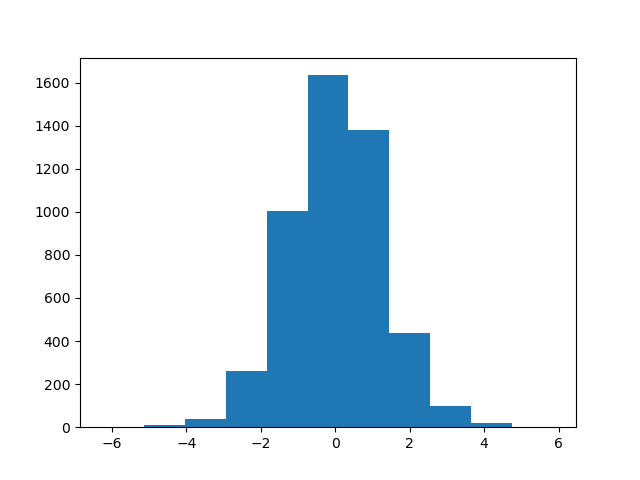

In [400]:
# MODE FROM g

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
g_hist = []
g_hist_y = []
for i in np.arange(0,core.g_spec.shape[0]):
    y,binEdges=np.histogram(core.g_spec[i,:],bins=15)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    g_hist.append(bincenters)
    g_hist_y.append(y)
    
g_hist = np.array(g_hist).T
g_hist_y = np.array(g_hist_y).T

idx_max_y = np.argmax(g_hist_y,axis=0)

g_mode = []
for i in np.arange(0,core.g_spec.shape[0]):
    g_mode.append(g_hist[idx_max_y[i],i])
    
g_mode = np.array(g_mode)

core.g_spec_mode = g_mode

core.ensemble_B(core.g_spec_mode, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
m_DSS_mode = core.B_ensemble[:,[0]].copy()

m_DSS_mode_pred = core.G@m_DSS_mode
m_DSS_mode_res = obs_sat.data.reshape(-1,1) - m_DSS_mode_pred

core.mode_res = m_DSS_mode_res

plt.figure()
plt.hist(m_DSS_mode_res,bins=11)
plt.show()

In [19]:
np.allclose(m_DSS_mode,m_DSS_mode_physical)

False

In [20]:
m_DSS_mode[:20]

array([[  6368.52448246],
       [ 31873.36707359],
       [ 58254.95704476],
       [ 84621.42852568],
       [109911.21645383],
       [132981.6676998 ],
       [152733.68855689],
       [168248.50016266],
       [178908.2992852 ],
       [184474.93024669],
       [185109.05861274],
       [181324.86246089],
       [173888.96929776],
       [163684.00842828],
       [151564.01406155],
       [138229.58013605],
       [124145.33037356],
       [109512.56722243],
       [ 94298.39092174],
       [ 78311.71951932]])

In [21]:
m_DSS_mode_physical[:20]

array([[ 52982.95735184],
       [186977.91590411],
       [201850.64165805],
       [-28402.61905454],
       [ 10828.25135831],
       [184285.52430131],
       [123651.34198683],
       [ 85403.37772165],
       [ 77061.19866303],
       [200886.42918446],
       [200864.41689906],
       [ 95023.41357247],
       [124462.14898402],
       [245061.36635365],
       [134864.04127081],
       [169122.98732978],
       [165383.07499751],
       [-39624.35489389],
       [  1286.05437531],
       [ 45975.05569814]])

In [368]:
core.m_DSS[:10,0]

array([ 144365.9737398 ,  103555.21725647,   55660.0840487 ,
         -4837.21140938,  -81273.1378201 , -170832.02410309,
       -264711.85571242, -352667.06038153, -427956.70102962,
       -488507.7442186 ])

In [22]:
g_spec = []

for i in np.arange(0,core.N_sim):

    C_vec, _ = mt_util.sh_expand_glq(core.m_DSS[:,[i]], core.grid_nmax, core.grid_w_shtools, 
                                     core.grid_zero, 30, geomag_r_at = core.r_cmb, geomag_scale = True)

    g_spec.append(C_vec)

g_spec = np.array(g_spec).T

In [23]:
core.ensemble_B(g_spec[:,[0]], nmax = 30, r_at = core.r_cmb, grid_type = "glq")
m_DSS_0 = core.B_ensemble[:,0].copy()
m_DSS_0[:10,0]

array([ 143077.31603348,  124019.41620856,   94679.54511289,
         54581.82761477,    3989.63110767,  -56106.25508049,
       -124038.32895459, -197548.09108769, -273907.23646158,
       -350076.05363689])

In [44]:
C_vec, _ = mt_util.sh_expand_glq(core.m_DSS[:,[0]], core.grid_nmax, core.grid_w_shtools, 
                                     core.grid_zero, 30, geomag_r_at = core.r_cmb, geomag_scale = False)



g_0 = np.array(C_vec).T

m_DSS_shtools = mt_util.sh_makegrid_glq(g_0, core.grid_nmax, core.grid_zero, 30, set_norm = 1)
m_DSS_shtools.shape

(31, 61)

<IPython.core.display.Javascript object>


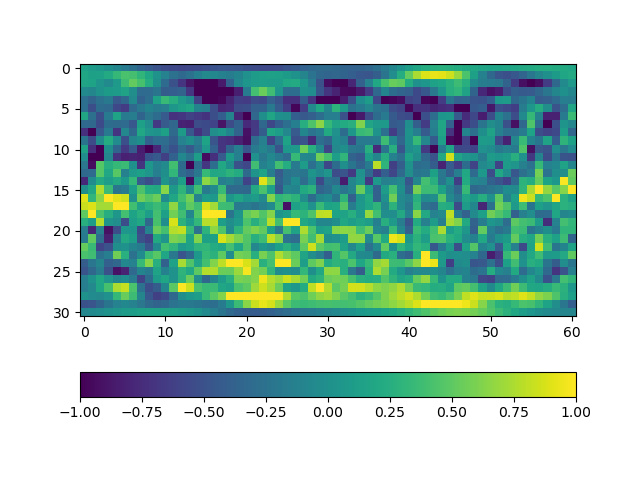

<IPython.core.display.Javascript object>


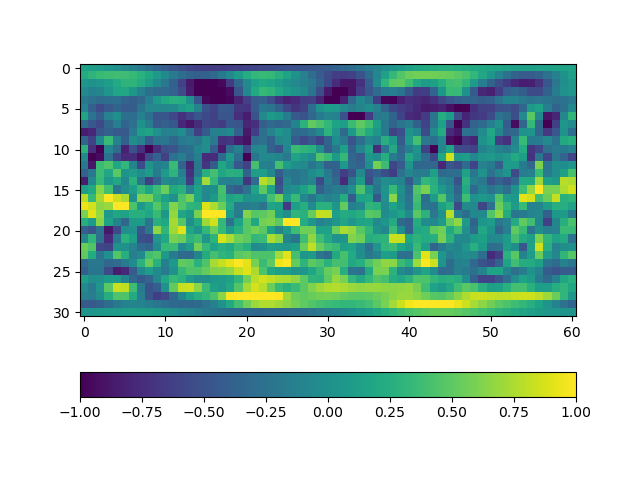

<IPython.core.display.Javascript object>


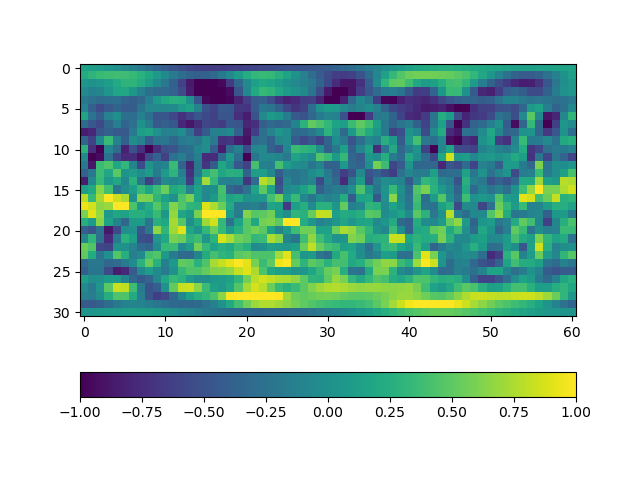

<IPython.core.display.Javascript object>


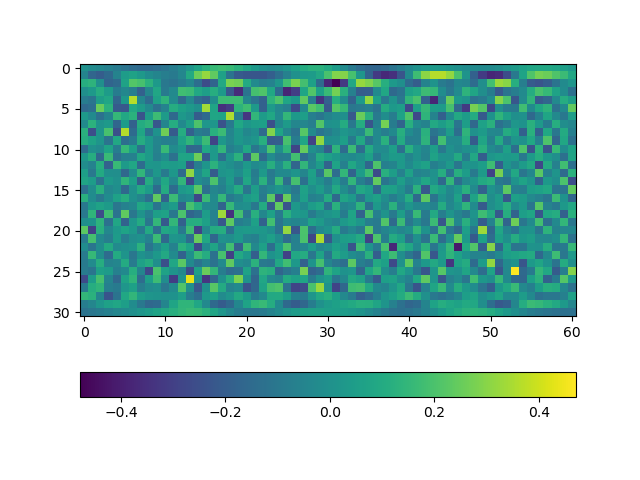

In [53]:
plt.figure()
plt.imshow(core.m_DSS[:,0].reshape(31,61)*10**(-6), vmin = -1, vmax = 1)
plt.colorbar(orientation='horizontal')
plt.show()

plt.figure()
plt.imshow(m_DSS_0[:,0].reshape(31,61)*10**(-6), vmin = -1, vmax = 1)
plt.colorbar(orientation='horizontal')
plt.show()

plt.figure()
plt.imshow(m_DSS_shtools*10**(-6), vmin = -1, vmax = 1)
plt.colorbar(orientation='horizontal')
plt.show()

plt.figure()
plt.imshow(core.m_DSS[:,0].reshape(31,61)*10**(-6)-m_DSS_0[:,0].reshape(31,61)*10**(-6))
plt.colorbar(orientation='horizontal')
plt.show()

<IPython.core.display.Javascript object>


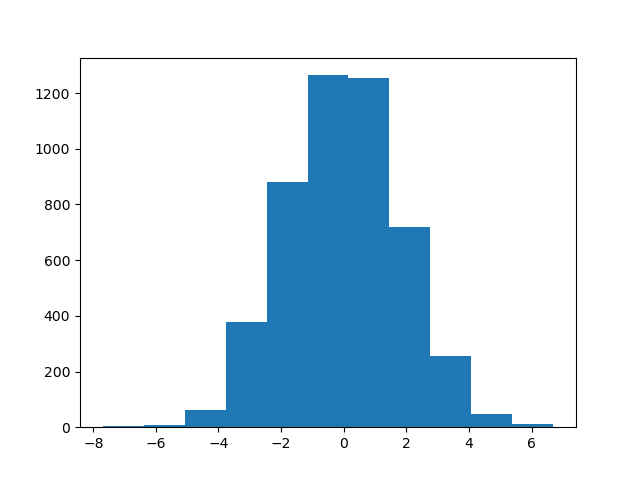

In [34]:
m_DSS_0_pred = core.G@m_DSS_0[:,[0]]
m_DSS_0_res = obs_sat.data.reshape(-1,1) - m_DSS_0_pred

plt.figure()
plt.hist(m_DSS_0_res,bins=11)
plt.show()

In [46]:
C_vec, _ = mt_util.sh_expand_glq(np.mean(core.m_DSS,axis=1), core.grid_nmax, core.grid_w_shtools, 
                                     core.grid_zero, 30, geomag_r_at = core.r_cmb, geomag_scale = False)



g_mean = np.array(C_vec).T

m_DSS_mean = mt_util.sh_makegrid_glq(g_mean, core.grid_nmax, core.grid_zero, 30, set_norm = 1)
m_DSS_mean.shape

(31, 61)

<IPython.core.display.Javascript object>


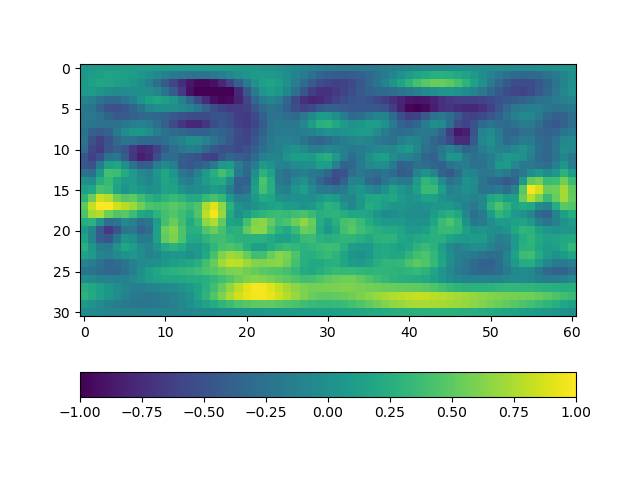

<IPython.core.display.Javascript object>


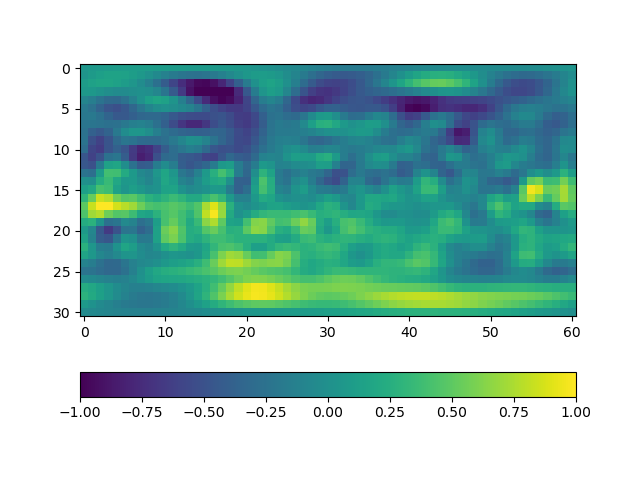

In [48]:
plt.figure()
plt.imshow(np.mean(core.m_DSS,axis=1).reshape(31,61)*10**(-6), vmin = -1, vmax = 1)
plt.colorbar(orientation='horizontal')
plt.show()

plt.figure()
plt.imshow(m_DSS_mean*10**(-6), vmin = -1, vmax = 1)
plt.colorbar(orientation='horizontal')
plt.show()

In [49]:
np.allclose(np.mean(core.m_DSS,axis=1),m_DSS_mean.reshape(-1,1))

False

In [50]:
np.mean(core.m_DSS,axis=1)[:10]

array([53109.45149768, 66709.67129997, 78203.87685937, 87286.01575549,
       93744.42628732, 97455.9982781 , 98453.22859538, 97067.69556418,
       94017.89115374, 90269.45776529])

In [51]:
m_DSS_mean.reshape(-1,1)[:10]

array([[ 49238.17891839],
       [ 64593.69823063],
       [ 78142.36773577],
       [ 89297.9228451 ],
       [ 97678.50301551],
       [103130.35562473],
       [105730.4428553 ],
       [105767.41204974],
       [103701.96597331],
       [100109.46925416]])

In [9]:
m_DSS_pred = core.G@np.mean(core.m_DSS, axis=1).reshape(-1,1)
m_DSS_res = obs_sat.data.reshape(-1,1) - m_DSS_pred

In [25]:
core.ensemble_B(g_CHAOS7, nmax = 20, r_at = core.r_cmb, grid_type = "glq")
m_chaos_test = core.B_ensemble[:,0].copy()
m_chaos_test[:10]

C_vec, _ = mt_util.sh_expand_glq(m_chaos_test, core.grid_nmax, core.grid_w_shtools, 
                                     core.grid_zero, 20, geomag_r_at = core.r_cmb, geomag_scale = True)
g_chaos_test = np.array(C_vec).T

In [26]:
np.allclose(g_CHAOS7,g_chaos_test)

True

In [27]:
print(g_CHAOS7[:20])
print(g_chaos_test[:20])

[-29411.89096668  -1459.67728167   4682.67454306  -2486.46913821
   2990.12831594  -2956.21538169   1679.12259407   -707.68723903
   1360.86162274  -2373.84610962    -89.04279653   1232.40445773
    243.06061146    539.76319958   -543.87500706    904.3860809
    811.19011063    281.93906258     93.27199703   -166.27588374]
[-29411.89096668  -1459.67728167   4682.67454306  -2486.46913821
   2990.12831594  -2956.21538169   1679.12259407   -707.68723903
   1360.86162274  -2373.84610962    -89.04279653   1232.40445773
    243.06061146    539.76319958   -543.87500706    904.3860809
    811.19011063    281.93906258     93.27199703   -166.27588374]


<IPython.core.display.Javascript object>


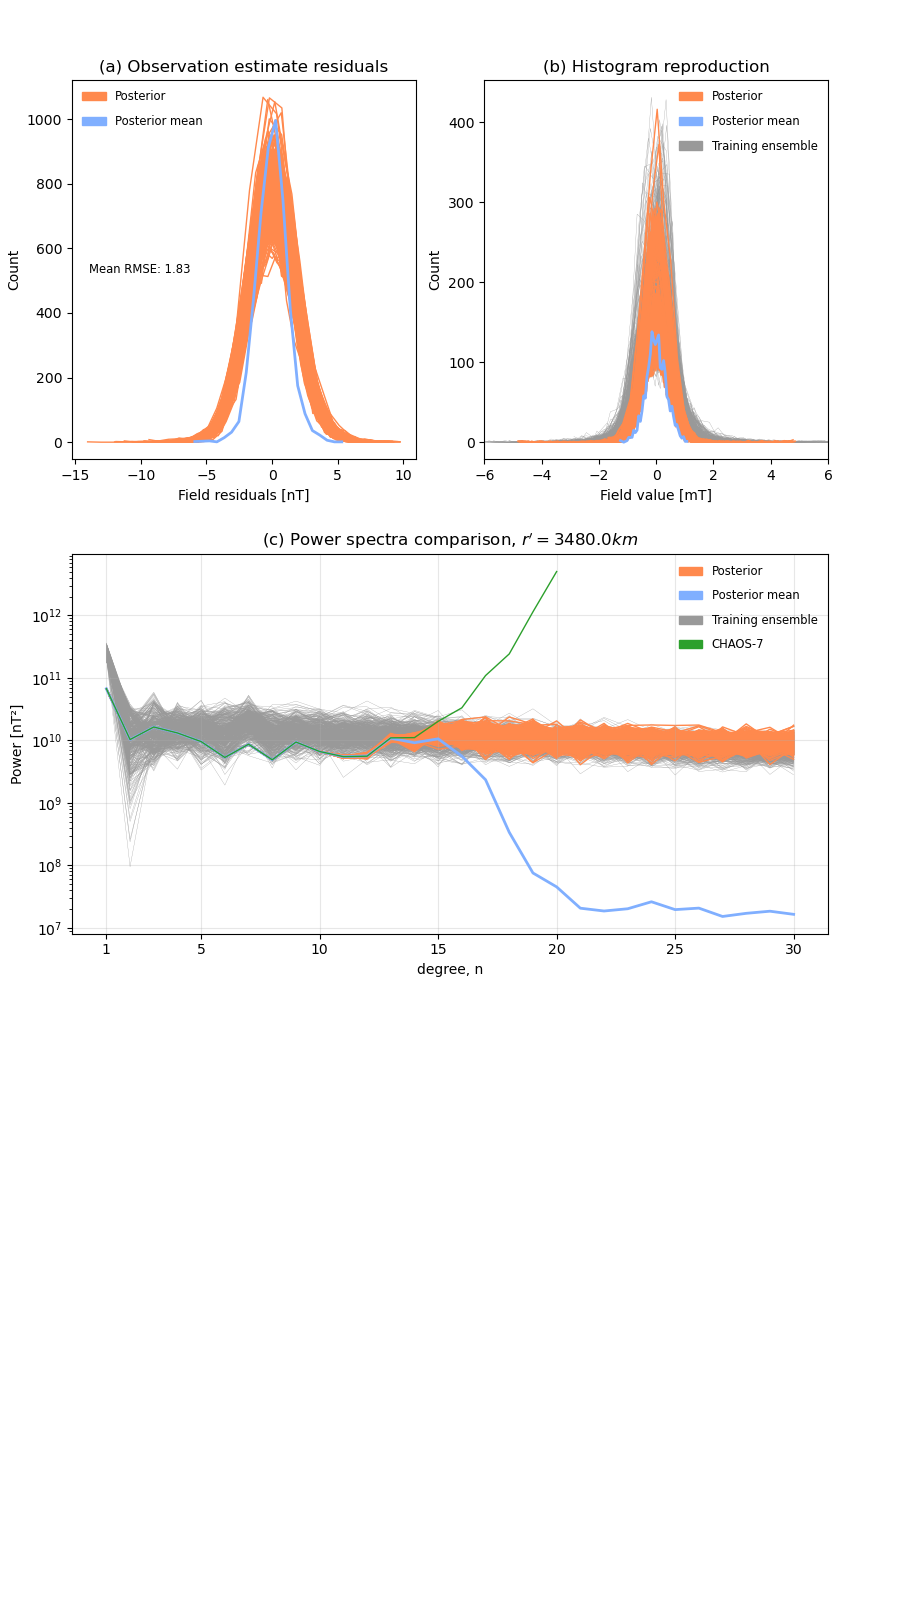

In [12]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

#m_equiv_lsq = core.m_equiv_lsq, m_mode = m_DSS_mode, pos_mean_res = m_DSS_res,

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, truth_obj = None, 
                              m_mode = None, pos_mean_res = m_DSS_res,
                              lags_use = 1000, spec_r_at = core.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, lwidth = 1.0, label_fontsize = "small", ens_prior = True,
                              model_dict = {"CHAOS-7"}, spec_chaos_time = date_start,
                              res_use = True, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = True, patch_legend = True, hist_ti_ens_limit = [-6,6],
                              figsize=(9,16), hist_ti_ens = "all", hist_density = False,
                              hist_bins = 41, res_bins = 21, hist_pos_mean = True,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_core_vires_swarm_obs", save_path = "images/",
                              save_dpi = 100)

In [13]:
core.grid_glq(nmax = 30, r_at = core.r_cmb)
set_nmax = shc_grid

#core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#zs_eqa = core.B_ensemble[:,0,:].copy()

#core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#zs_mean_eqa = core.B_ensemble[:,0].copy()
zs_mean_eqa = np.mean(core.m_DSS,axis=1)

<IPython.core.display.Javascript object>


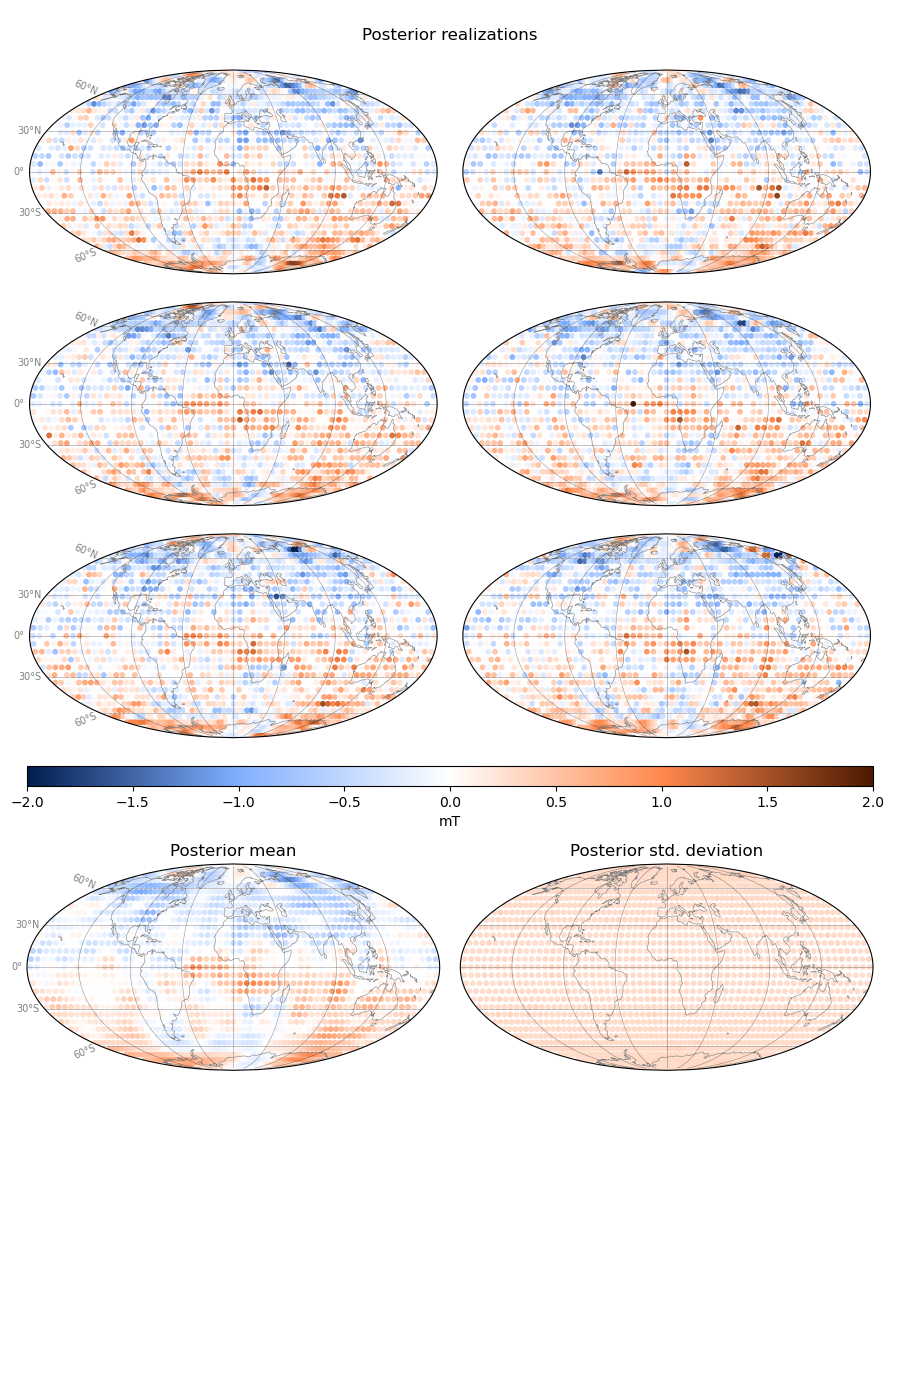

In [21]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, core.m_DSS, 
                        field_compare = None, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 4, tile_size_column = 2, 
                        figsize=(9,14), limit_for_SF = 10**6, point_size = 10, cbar_mm_factor = 1, cbar_limit = [-2,2],
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.2, right=0.97, top=0.95, wspace = 0.05, hspace=0.15, 
                        savefig = False, save_string = "case_core_vires_swarm_obs_ps", save_path = "images/",
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

In [28]:
core.grid_glq(nmax = 30, r_at = core.r_cmb)

g_mean, _ = mt_util.sh_expand_glq(zs_mean_eqa, core.grid_nmax, core.grid_w_shtools, core.grid_zero, set_nmax, geomag_r_at = core.r_cmb)        
g_mean = np.array(g_mean).T

core.grid_glq(nmax = 400, r_at = core.r_cmb)
core.ensemble_B(g_mean, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa_g = core.B_ensemble[:,0].copy()

core.ensemble_B(g_DSS_mode_physical, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
zs_mode_eqa = core.B_ensemble[:,0].copy()

core.ensemble_B(core.g_equiv_lsq, nmax = 30, r_at = core.r_cmb, grid_type = "glq")
zs_lsq = core.B_ensemble[:,0].copy()

#zs_g_Br = core.ensemble_B(g_Br, nmax = 40, r_at = core.r_cmb, grid_type = "glq")
#zs_g_Br = core.B_ensemble[:,0].copy()

core.ensemble_B(g_CHAOS7, nmax = 13, r_at = core.r_cmb, grid_type = "glq")
zs_chaos = core.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


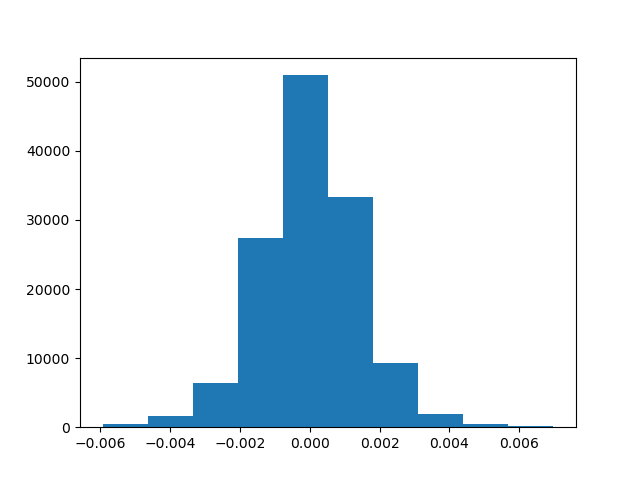

In [453]:
plt.figure()
plt.hist(zs_g_Br*10**(-6)-zs_mean_eqa*10**(-6))
plt.show()

In [31]:
zs_lsq.shape

(321201,)

In [32]:
zs_mean_eqa_g.shape

(321201,)

<IPython.core.display.Javascript object>


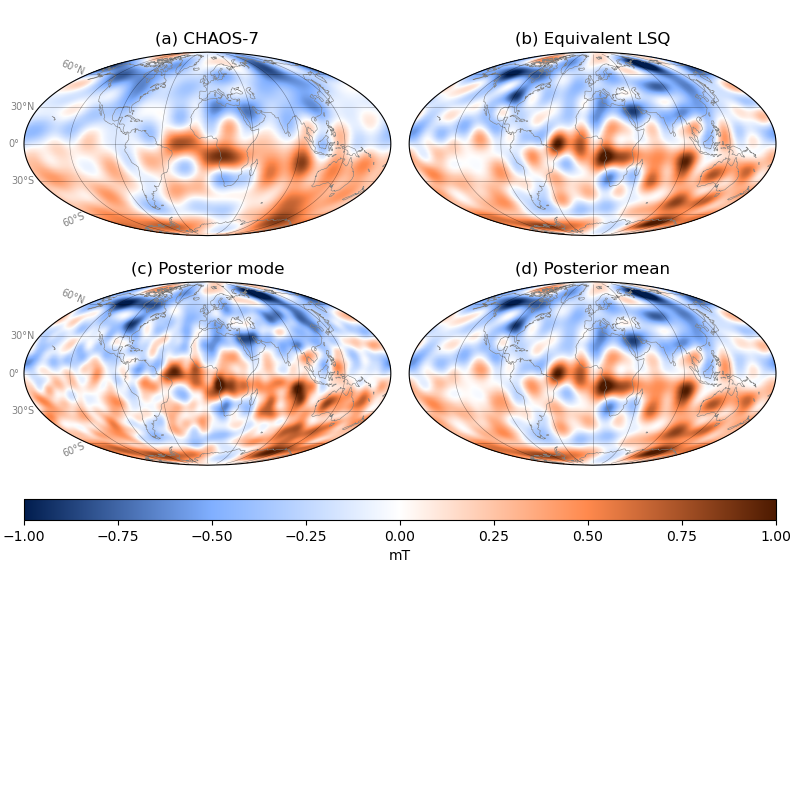

In [34]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

#zs_lsq = np.array(core.m_equiv_lsq).reshape(-1,)
#ul = ["CHAOS-7", zs_chaos]
#ur = ["Equivalent LSQ", zs_lsq]
#lr = ["Posterior mean", zs_mean_eqa]
#ll = ["Posterior mode", m_DSS_mode_physical]

ul = ["CHAOS-7", zs_chaos]
ur = ["Equivalent LSQ", zs_lsq]
lr = ["Posterior mean", zs_mean_eqa_g]
ll = ["Posterior mode", zs_mode_eqa]

mt_util.plot_map_compare_tiles(core.grid_phi, 90-core.grid_theta, ul, ur, ll, lr, 
                               tile_size_row = 2, tile_size_column = 2, 
                               figsize=(8,8), limit_for_SF = 10**6, point_size = 1, 
                               left=0.03, bottom=0.35, right=0.97, top=0.95, wspace = 0.05, hspace=0.15, 
                               coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                               savefig = False, save_string = "case_core_vires_swarm_obs", 
                               save_dpi = 100, save_path = "images/", 
                               projection = ccrs.Mollweide(), cbar_limit = [-1,1], cbar_h = 0.1, 
                               cbar_text = "mT", cbar_text_color = "grey", use_gridlines = True, 
                               gridlines_width = 0.4, gridlines_alpha = 0.4)

<IPython.core.display.Javascript object>


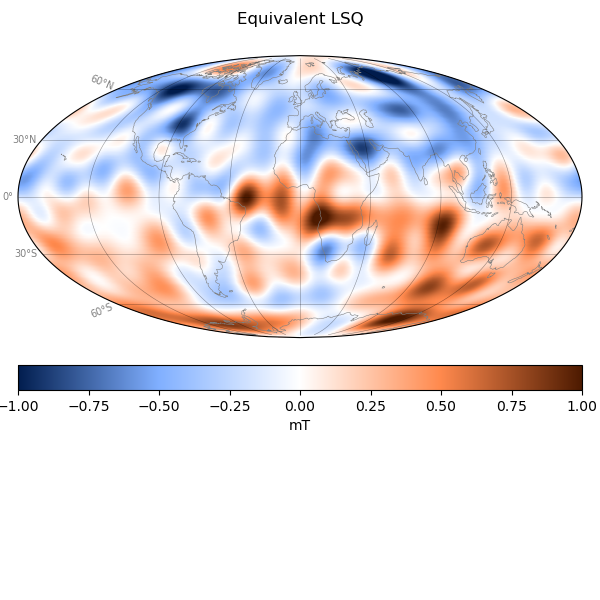

<IPython.core.display.Javascript object>


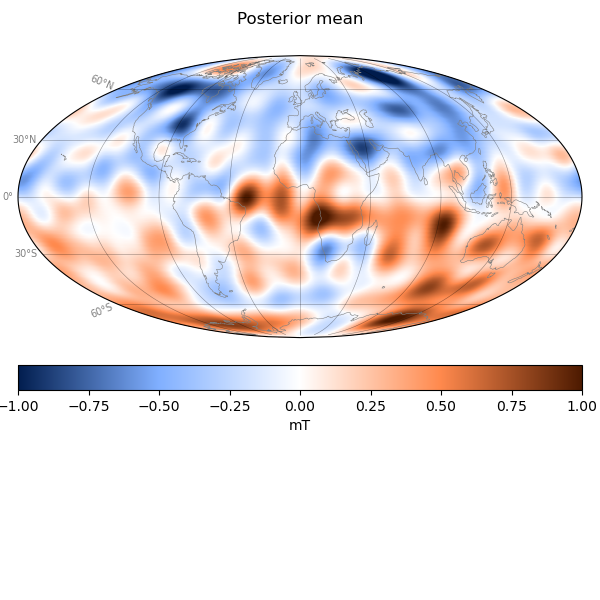

<IPython.core.display.Javascript object>


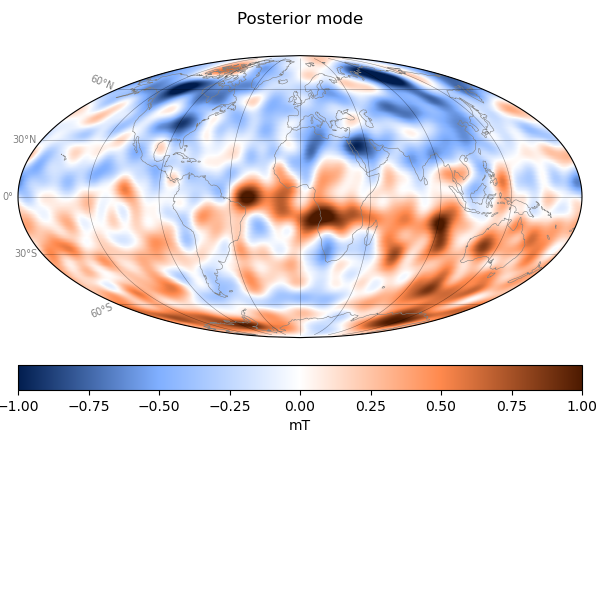

<IPython.core.display.Javascript object>


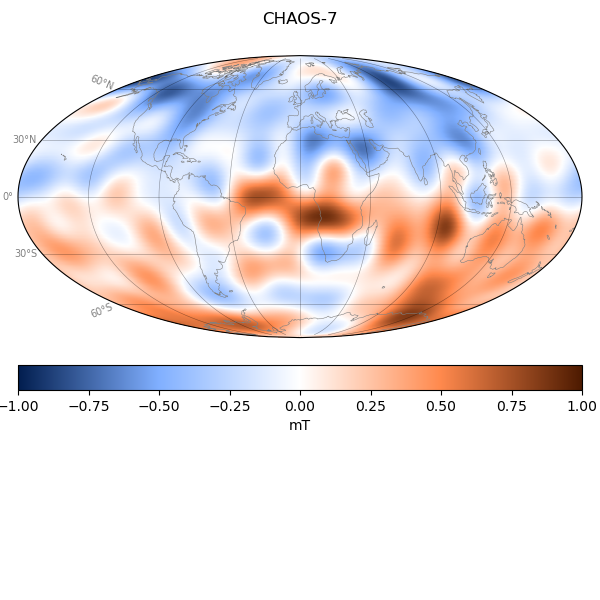

In [324]:
limit_data = [-1,1]

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_lsq, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Equivalent LSQ', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_mean_eqa, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mean', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_mode_eqa, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Posterior mode', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_chaos, limits_data = limit_data,
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='CHAOS-7', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)



<IPython.core.display.Javascript object>


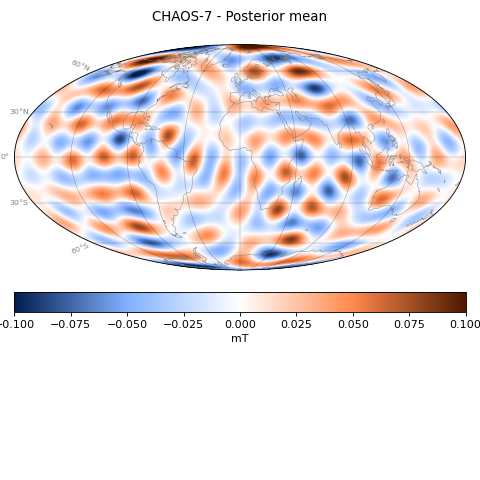

<IPython.core.display.Javascript object>


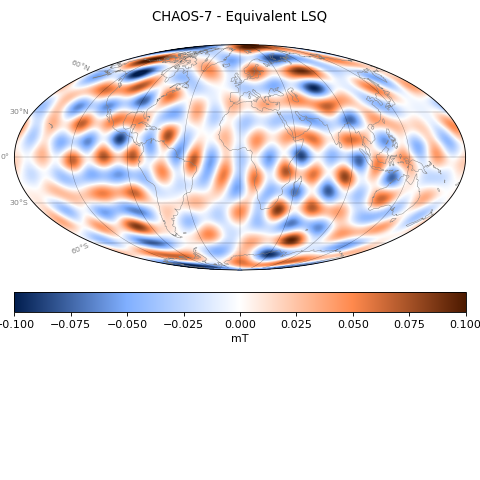

In [36]:
mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_chaos-zs_mean_eqa,
                cbar_h = 0.075, unit_transform_n_to_m = True, limits_data = [-0.1,0.1],
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='CHAOS-7 - Posterior mean', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=zs_chaos-zs_lsq,
                cbar_h = 0.075, unit_transform_n_to_m = True, limits_data = [-0.1,0.1],
                cbar_text = "mT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='CHAOS-7 - Equivalent LSQ', point_size=1,
                savefig = False, save_dpi = 100, save_string ="vre_obs",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

In [14]:
print(core)


______current attributes______

a:                  6371.2
r_sat:              6721.2
r_cmb:              3480.0
rad:                0.017453292519943295
mu0:                1.2566370614359173e-06
comment:            Swarm observations with tapered ensemble as prior
class_abs_path:     /home/mikotz/spherical_direct_sequential_simulation
N_SH:               30
N_SH_secondary:     None
sim_type:           core_ens
grid_zero:          (31,), Max/Min: 1.00 / -1.00
grid_w_shtools:     (31,), Max/Min: 0.10 / 0.01
grid_shape:         (2,), Max/Min: 61.00 / 31.00
grid_w:             (1891,), Max/Min: 0.10 / 0.01
grid_radial:        (1891,), Max/Min: 3480.00 / 3480.00
grid_theta:         (1891,), Max/Min: 175.63 / 4.37
grid_phi:           (1891,), Max/Min: 354.10 / 0.00
grid_N:             1891
grid_nmax:          30
r_grid:             3480.0
grid:               (1891, 2)
sph_d:              None
lon:                (1891,), Max/Min: 354.10 / 0.00
lat:                (1891,), Max/Min: 85.63 /

In [16]:
core.g_lsq_equiv = core.g_equiv_lsq

<IPython.core.display.Javascript object>


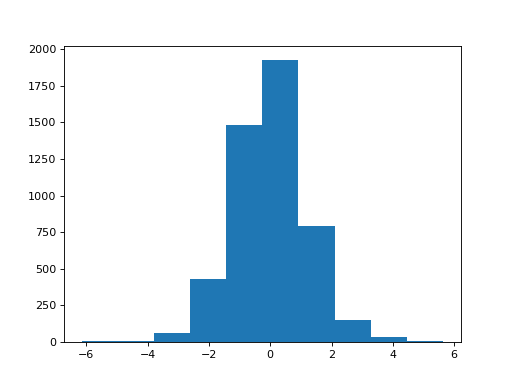

In [18]:
plt.figure()
plt.hist(core.lsq_equiv_res)
plt.show()